# library

In [9]:
from __future__ import print_function
from IPython.display import display, clear_output
from datetime import datetime, timedelta
from itertools import product
from pandas.plotting import register_matplotlib_converters

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

pd.options.display.max_columns = None
register_matplotlib_converters()

%matplotlib inline

In [10]:
# random strategy, gamma=0.9
expected_values_random = np.array([
    [ 3.3,  8.8,  4.4,  5.3,  1.5],
    [ 1.5,  3.0,  2.3,  1.9,  0.5],
    [ 0.1,  0.7,  0.7,  0.4, -0.4],
    [-1.0, -0.4, -0.4, -0.6, -1.2],
    [-1.9, -1.3, -1.2, -1.4, -2.0],
])
# optimal strategy, gamma=0.9
expected_values = np.array([
    [22.0, 24.4, 22.0, 19.4, 17.5],
    [19.8, 22.0, 19.8, 17.8, 16.0],
    [17.8, 19.8, 17.8, 16.0, 14.4],
    [16.0, 17.8, 16.0, 14.4, 13.0],
    [14.4, 16.0, 14.4, 13.0, 11.7]
])

# Agent

In [11]:
from enum import Enum


# 엑션 클래스
class Action(Enum):
    NORTH = 'N', 0, lambda x: (x[0] - 1, x[1]), (0, 1)
    EAST = 'E', 1, lambda x: (x[0], x[1] + 1), (1, 0)
    WEST = 'W', 2, lambda x: (x[0], x[1] - 1), (-1, 0)
    SOUTH = 'S', 3, lambda x: (x[0] + 1, x[1]), (0, -1)
    def __init__(self, display_name, index, transition, direction):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # numpy row-major coordinates
        self.direction = direction  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name

In [12]:
# agent 기본 클래스
class Agent(object):
    def __init__(self, name):
        self.name = name
        
    def policy(self, state):
        """Return an Action given STATE"""
        raise NotImplementedError()

In [14]:
# 무작위 행동을 하는 agent
class RandomAgent(Agent):
    def __init__(self, name='Random'):
        super().__init__(name)
        self.state_values = np.random.randn(5, 5)
    
    def policy(self, state):
        return random.choice([a for a in Action])

In [33]:
# Greedy한 행동을 하는 agent
class GreedyAgent(Agent):
    def __init__(self, state_values=None, name='Optimal', gamma=0.9):
        super().__init__(name)
        if state_values is None:
            state_values = np.random.randn(5, 5)
        self.state_values = state_values  # v(s)
        self.gamma = gamma
        
        self.environment = Gridworld()
        
    def policy(self, state):
        action = None
        max_action_value = -1000
        for a in Action:
            self.environment.set_state(state)
            s1, r = self.environment.transition(a)

            # to-do
            action_value = r + self.gamma * self.state_values[s1]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value    
            # greedy 쓰려고 비워놨음
            
                
        return action

In [34]:
# e-greed 행동을 하는 agent
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, epsilon=1e-2, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def policy(self, state):
        # to-do 
                
        return super().policy(state)

In [35]:
# 몬테카를로 등에서 환경에 대한 모델없이 학습하여 최적 정책을 찾는 agent
class LearnedAgent(Agent): 
    def __init__(self, name='Learned', gamma=0.9, dim=5, epsilon=0):
        super().__init__(name)
        self.action_values = np.random.randn(5, 5, 4)  # q(s, a)
        self._policy = {s: random.choice([a for a in Action])
                        for s in product(range(dim), range(dim))}
        self.gamma = gamma
        self.epsilon = epsilon
        
    # e-greed 행동
    def policy(self, state):
        # to-do 
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])

        return self._policy[state]
    
    def update_state_policy(self, s):
        old_action = self._policy[s]
        stable = True
        max_action_value = -1000
        for a in Action:
            action_value = self.action_values[(s[0], s[1], a.index)]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value
        if action != old_action:
            policy_stable = False
        self._policy[s] = action
        return stable        
    
    def policy_improvement(self):
        policy_stable = True
        for s in self._policy.keys():
            stable = self.update_state_policy(s)
            if not stable:
                policy_stable = False
            
        return policy_stable

# Environment

In [36]:
class Gridworld(object):
    def __init__(self, initial_state=(0, 0)):
        self.dim = 5
        self.state = initial_state
        
    def set_state(self, state):
        self.state = state

    def _transition_state(self, action):
        """Try to apply the ACTION and check whether it is valid"""
        x, y = action.transition(self.state)
        if x < 0 or x >= self.dim:
            return self.state
        elif y < 0 or y >= self.dim:
            return self.state
        return x, y
    
    def transition(self, action):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = 0
        if self.state == (0, 1):  # special state A            
            new_state = (4, 1)
            reward = 10
        elif self.state == (0, 3):  # specal state B
            new_state = (2, 3)
            reward = 5
        else:
            new_state = self._transition_state(action)
            # invalid move
            if new_state == self.state:
                reward = -1

        self.state = new_state
        return new_state, reward     

In [37]:
def display_state_values(state_values, title=None, save_path=None, plot_actions=True):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    if title:
        ax.set_title(title)
    # Transform row-major numpy coords to matplotlib coords        
    transformed_values = np.rot90(state_values.T)
    im = ax.imshow(transformed_values, cmap='hot')
    fig.colorbar(im, ax=ax)
    
    if plot_actions:
        agent = GreedyAgent(state_values)
        for s in product(range(5), range(5)):
            action = agent.policy(s)
            dx, dy = action.direction

            # Transform row-major numpy coords to matplotlib coords
            x, y = s[1], 4 - s[0]
            ax.arrow(x - 0.25 * dx, y - 0.25 * dy, 0.5 * dx, 0.5 * dy, head_width=0.05)
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)
    if save_path:
        plt.savefig(save_path)
    plt.show()

    
def display_state(state, fig=None, ax=None):
    if ax == None:        
        fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
    grid = np.zeros((5, 5))
    grid[state[0], state[1]] = 1
    ax.imshow(grid, cmap='viridis')
    display(fig)
    clear_output(wait=True)
    plt.show()

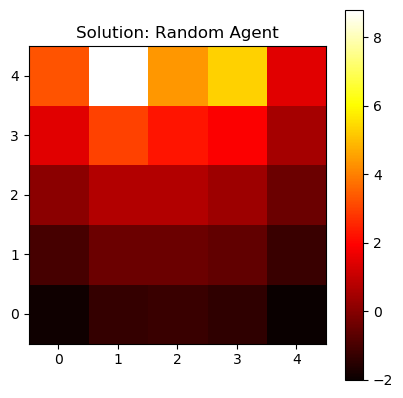

In [38]:
display_state_values(expected_values_random, title='Solution: Random Agent', plot_actions=False)

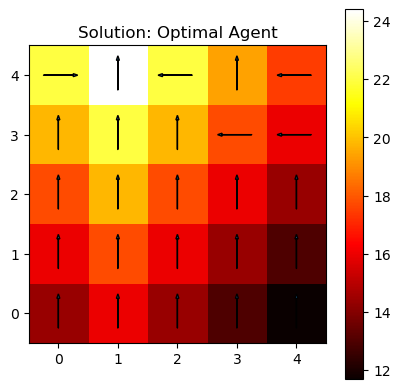

In [39]:
display_state_values(expected_values, title='Solution: Optimal Agent')

# DP - value iteration

In [40]:
def value_iteration(gamma=0.9, epsilon=1e-4):
    # state 및 환경 초기화
    #각 state별로 가치가 어떻게 되어있는지 출력을 하고 시각화를 하는 예제
    state_values = np.random.randn(5, 5) 
    dim = 5
    environment = Gridworld()

    delta = 1000
    while delta > epsilon: # 가치함수 변화량이 매우 작아지면 종료 (어느정도 변화량이 적어지면 종료를 하겠다!)
        delta = 0
        for s0 in product(range(dim), range(dim)): # 모든 state에 대해서 반복문 실행 (0,1이 나올수도 있고 0,2가 나올수도 있고 등등..)
            v_s0 = state_values[s0] # 선택된 state에 대한 현재 가치함수 (s0에 대한 현재 가치값)


            ######이 부분 추가하기!!######
            ########################
                        #value iteration
            optimal_action_value = -10000
            for a in Action:
                environment.set_state(s0)
                s1, r = environment.transition(a)
                v_s1 = state_values[s1]

                action_values = r + gamma +v_s1
                optimal_action_value = max(action_values,optimal_action_value)
            state_values[s0] = optimal_action_value

            # 가치 반복에서는 greedy하게 action을 선택(현재 가장 좋은 action 선택)
            # environment.set_state(s0)로 현재 state 설정
            # environment.transition(a)로 action을 가하여 이동한 state와 reward 획득
            # 가장 높은 가치를 갖는 action 탐색 
            # state_values 업데이트

            #vk+1 state에 대한 새로운 가치를 받아와서 state_value를 업데아트 해보기!(delta를 계산을 해보고)

            # to-do
            
            delta += abs(v_s0 - optimal_action_value) # 가치함수 변화량이 매우 작아지면 (??종료 초기값이랑 delta 빼서 뭐)

    return state_values

In [41]:
vi_state_values = value_iteration()
display_state_values(vi_state_values, title='Value Iteration')
vi_state_values

KeyboardInterrupt: 

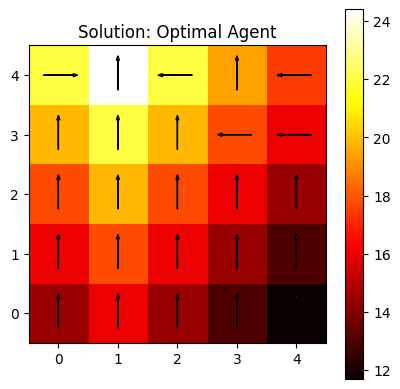

array([[22. , 24.4, 22. , 19.4, 17.5],
       [19.8, 22. , 19.8, 17.8, 16. ],
       [17.8, 19.8, 17.8, 16. , 14.4],
       [16. , 17.8, 16. , 14.4, 13. ],
       [14.4, 16. , 14.4, 13. , 11.7]])

In [ ]:
display_state_values(expected_values, title='Solution: Optimal Agent')
expected_values

# Monte Carlo

In [ ]:

#몬테카를로 실습
def mc_prediction(gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    #여기서는 agent가 랜덤이었음!
    agent = RandomAgent(name='First-Value MC Prediction: Random Agent') # 만약 탐욕적 정책 agent를 사용한다면 학습이 실패함(모든 state를 방문하지 못하기 때문)
    returns = {s: (0, 0) for s in product(range(dim), range(dim))} # 이득
    environment = Gridworld()

    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'MC Prediction: Iteration {i}')
        
        # 시뮬레이션 수행(에피소드 수행)
        s0 = (random.randint(0, 4), random.randint(0, 4)) # 무작위 시작위치
        environment.set_state(s0)
        episode = [s0]  # 에피소드 정보 추가(s0, a0, s1, r1, a1, s2, r2, a2, s3...)
        for _ in range(T): # T: 최대 에피소드 길이
            # to-do
            a0 = agent.policy(s)
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1])
            s0 = s1

        # 에피소드의 끝 부분부터 이득값 업데이트
        ret = 0 # 이득값
        j = T - 1
        episode_returns = {} # 에피소드를 진행하며 지나친 state에서의 이득값 업데이트
        while j > 0:
            # to-do
            r1 = episode[3*j + 3] # reward(앞에서 빼옴 이미 이전 step의 reward임),
            s0 = episode[3*j -1] # state 앞에서 빼오기!
            j -= 1

            ret = r1+ gamma * ret
            episode_returns[s0] = ret # 이런 리턴값을 얻었다~ 이 에피소드에서는! 이렇게 넣어두기!
            


        # state values v(s) 업데이트
        for s, ret in episode_returns.items(): # 아이템들을 빼와서 (state랑 리턴값을 빼옴)
            # to-do
            mean_ret, c = returns[s]
            returns[s] = ((mean_ret*c+ret) / (c+1), c+1)
            agent.state_values[s] = returns[s][0]


    return agent

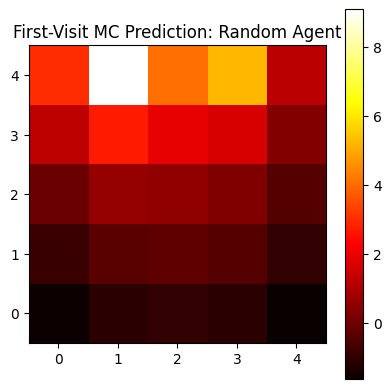

array([[ 2.98540603,  9.07475366,  4.0480447 ,  5.226059  ,  1.18772246],
       [ 1.22256509,  2.71264464,  1.89642754,  1.65799898,  0.32780257],
       [-0.0705809 ,  0.59527715,  0.52299   ,  0.29088951, -0.43774269],
       [-0.85812579, -0.34668997, -0.25800955, -0.4528496 , -0.99813033],
       [-1.58193352, -1.12528862, -0.96856086, -1.12375309, -1.62805731]])

In [ ]:
mcp_agent = mc_prediction(iterations=int(1e6), T=16)
display_state_values(mcp_agent.state_values, title='First-Visit MC Prediction: Random Agent', plot_actions=False)
mcp_agent.state_values

In [42]:
def mc_control(gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    # 근데 여기서는 Agent가 e greedy임
    agent = LearnedAgent(name='MC Control', epsilon=0.01)  # e-greedy 정책 에이전트
    returns = {(x, y, a): (0, 0) for x, y, a in product(range(dim), range(dim), [a for a in Action])}
    environment = Gridworld()

    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.action_values.max(axis=2), title=f'MC Control: Iteration {i}')

        # 시뮬레이션
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        s0 = (x, y)
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            # to-do
            s1,r1 = environment.transition(a0)
            episode.extend([a0, s1, r1])
            a0 = agent.policy(s1)

        # 이득값 업데이트
        ret = 0
        j = T - 1
        episode_returns = {}
        while j > 0:
            # to-do

        # 가치함수 업데이트
        for (x, y, a), ret in episode_returns.items():
            # to-do
            

        # 에이전트의 정책 업데이트트
        agent.policy_improvement()
        
    return agent

IndentationError: expected an indented block (4142697768.py, line 33)

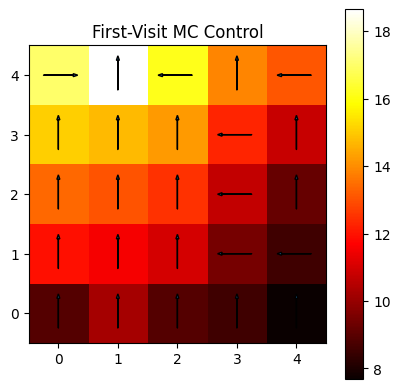

array([[16.99542012, 18.64664474, 16.12319893, 13.8570847 , 13.09806029],
       [15.07473257, 14.71218864, 14.19594149, 12.29260978, 10.80464581],
       [13.40369036, 13.04059951, 12.5243148 , 10.6992124 ,  9.19498248],
       [11.93290826, 11.54879308, 10.99696322,  9.48360619,  8.58282918],
       [ 8.9022931 , 10.2244661 ,  8.89948673,  8.57422998,  7.68775949]])

In [ ]:
mcc_agent = mc_control(iterations=int(1e6), T=16)
display_state_values(mcc_agent.action_values.max(axis=2), title='First-Visit MC Control')
mcc_agent.action_values.max(axis=2)

# TD

In [43]:
def td_prediction(alpha, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = RandomAgent(name='TD Prediction: Random Agent')
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'TD Prediction: Iteration {i}')
        
        # 시뮬레이션
        s0 = (random.randint(0, 4), random.randint(0, 4))
        environment.set_state(s0)
        for _ in range(T): # 최대 에피소드 길이만큼 수행
            # to-do
            
            # Agent의 정책에 따라 action을 선택하고, 환경에 입력하여 s1과 r1을 획득
            
            # 가치함수 업데이트
            
            # Prep the next timestep
            s0 = s1
            
    return agent

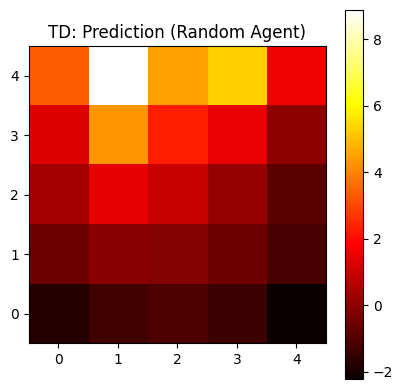

array([[ 3.4049576 ,  8.88381718,  4.4923571 ,  5.28228463,  1.60114413],
       [ 1.3130444 ,  4.27857392,  2.36273356,  1.45494007, -0.02548308],
       [ 0.36268606,  1.43299278,  0.90623621,  0.096198  , -0.863637  ],
       [-0.58185486, -0.11791593, -0.16949215, -0.55507565, -1.23462841],
       [-1.78309965, -1.28392662, -1.11506457, -1.38068724, -2.23907905]])

In [ ]:
tdp_agent = td_prediction(0.05, iterations=int(1e4), T=16)
display_state_values(tdp_agent.state_values, title='TD: Prediction (Random Agent)', plot_actions=False)
tdp_agent.state_values

In [44]:
# SARSA 알고리즘
def td_control(alpha, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = LearnedAgent(name='TD Control', epsilon=0.01)  # 모델이 필요없는 e-greedy 에이전트
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.action_values.max(axis=2), title=f'TD Control: Iteration {i}')

        # 시뮬레이션 수행 (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        sa0 = (x, y, a0.index)
        environment.set_state((x, y))

        for _ in range(T):
            # to-do
            s1,r1 = environment.transition(a0)
            a1 = agent.policy(s1)

            sa1 = (s1[0], s1[1], a1.index)
            q0 = agent.action_values[sa0]
            q1 = agent.action_values[sa1]
            
            # q value 업데이트 및 정책 업데이트
            agent.action_values[sa0] = q0 + alpha * (r1 + gamma * q1 - q0)
            agent.update_state_policy((sa0[0], sa0[1]))
            # to-do

            
            # Prep the next timestep            
            a0 = a1
            sa0 = sa1 

    return agent

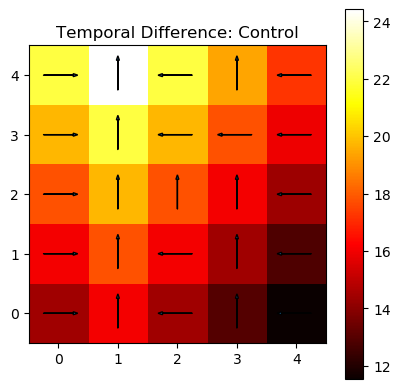

array([[21.97642827, 24.4194281 , 21.97383064, 19.39122849, 17.27503413],
       [19.77970572, 21.97748529, 19.77973676, 17.80176308, 15.96584687],
       [17.80172417, 19.77973676, 17.8015606 , 16.02158677, 14.37187051],
       [16.02158677, 17.80176308, 16.02158668, 14.41930527, 12.8962254 ],
       [14.4193719 , 16.02158677, 14.41869205, 12.9652735 , 11.53982779]])

In [45]:
tdc_agent = td_control(0.05, iterations=int(1e4), T=16)
display_state_values(tdc_agent.action_values.max(axis=2), title='Temporal Difference: Control')
tdc_agent.action_values.max(axis=2)